In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import Conv2D,Conv2DTranspose,BatchNormalization,LeakyReLU,Input,concatenate,Dropout,UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from keras.models import Model
import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path_gray = '/content/drive/My Drive/Colab Notebooks/landscape Images/gray/'
path_color = '/content/drive/My Drive/Colab Notebooks/landscape Images/color/'

In [4]:
import zipfile
import os

# Define the path to the ZIP file
zip_path = '/content/drive/My Drive/Colab Notebooks/dataset.zip'
# Define the directory to unzip the files to
unzip_dir = '/content/drive/My Drive/Colab Notebooks/'

# Create the directory if it does not exist
os.makedirs(unzip_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

In [5]:
# sortiranje dobijenih podataka
def sort_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [6]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, color_path, gray_path, batch_size, image_size, image_names, pipeline = None, shuffle=True):
        'Initialization'
        self.color_path = color_path
        self.grayscale_path = gray_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_names = image_names
        self.shuffle = shuffle
        self.pipeline = pipeline
        self.indexes = np.arange(len(self.image_names))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_names) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_color_images = []
        batch_gray_images = []

        for i in indexes:
            rgb_image = cv2.imread(os.path.join(self.color_path, self.image_names[i]))
            rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
            rgb_image = cv2.resize(rgb_image, (self.image_size, self.image_size))
            rgb_image = rgb_image.astype("float32") / 255.0
            batch_color_images.append(img_to_array(rgb_image))

            grayscale_image = cv2.imread(os.path.join(self.grayscale_path, self.image_names[i]), cv2.IMREAD_GRAYSCALE)
            grayscale_image = cv2.resize(grayscale_image, (self.image_size, self.image_size))
            grayscale_image = grayscale_image.astype("float32") / 255.0
            grayscale_image = np.expand_dims(grayscale_image, axis=-1)
            batch_gray_images.append(grayscale_image)

        batch_color_images = np.array(batch_color_images)
        batch_gray_images = np.array(batch_gray_images)

        if self.pipeline is not None:
            batch_color_images, batch_gray_images = self.augment_images(batch_color_images, batch_gray_images)

        return batch_gray_images, batch_color_images

    def augment_images(self, color_images, gray_images):
        # Apply augmentations to color and grayscale images
        aug_color_images = self.pipeline(images=color_images)
        aug_gray_images = self.pipeline(images=gray_images)
        return aug_color_images, aug_gray_images

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_names))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
# Create the augmentation pipeline
pipeline = iaa.Sequential([
    iaa.Rot90((1, 3)),  # randomly rotate image from 90, 180, 270 degrees
    iaa.Fliplr(0.5),  # horizontally flip 50% of the images
    iaa.Flipud(0.5),  # vertically flip 50% of the images
])

In [7]:
def up(filters, kernel_size, dropout=False):
    upsample = Sequential()
    upsample.add(Conv2DTranspose(filters, kernel_size, padding='same', strides=2))
    if dropout:
        upsample.add(Dropout(0.2))
    upsample.add(LeakyReLU())
    return upsample

In [8]:
def down(filters, kernel_size, apply_batch_normalization=True):
    downsample = Sequential()
    downsample.add(Conv2D(filters, kernel_size, padding='same', strides=2))
    if apply_batch_normalization:
        downsample.add(BatchNormalization())
    downsample.add(LeakyReLU())
    return downsample

In [9]:
def build_autoencoder():
    inputs = Input(shape= [256,256,1])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)

    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = concatenate([u5,inputs])
    output = Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [10]:
# Podela podataka na trening i test skup podataka i pravljenje generatora podataka.
image_names = sort_alphanumeric(os.listdir(path_color))
TRAINING_SIZE = int(len(image_names) * 0.8)
train_image_names = image_names[:TRAINING_SIZE]
test_image_names = image_names[TRAINING_SIZE:]

In [11]:
len(image_names)

5163

In [12]:
train_generator = DataGenerator(path_color,path_gray,32,256,train_image_names)
test_generator = DataGenerator(path_color,path_gray,8,256,test_image_names)

In [13]:
# Build and compile the model
autoencoder = build_autoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['accuracy'])

# Check the model summary to see the tensor shapes
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 128)        1280      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          147584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          296192    ['sequential_1[0][0]']        
                                                                                              

In [14]:
history = autoencoder.fit(train_generator, validation_data=test_generator, epochs=50)

Epoch 1/50
129/129 [==============================] - 150s 601ms/step - loss: 0.0953 - accuracy: 0.4050 - val_loss: 0.0714 - val_accuracy: 0.2831
Epoch 2/50
129/129 [==============================] - 69s 536ms/step - loss: 0.0602 - accuracy: 0.4612 - val_loss: 0.0593 - val_accuracy: 0.4541
Epoch 3/50
129/129 [==============================] - 69s 530ms/step - loss: 0.0563 - accuracy: 0.4729 - val_loss: 0.0603 - val_accuracy: 0.5057
Epoch 4/50
129/129 [==============================] - 77s 593ms/step - loss: 0.0537 - accuracy: 0.4856 - val_loss: 0.0575 - val_accuracy: 0.4165
Epoch 5/50
129/129 [==============================] - 68s 529ms/step - loss: 0.0519 - accuracy: 0.4907 - val_loss: 0.0542 - val_accuracy: 0.4798
Epoch 6/50
129/129 [==============================] - 68s 528ms/step - loss: 0.0509 - accuracy: 0.4993 - val_loss: 0.0556 - val_accuracy: 0.4256
Epoch 7/50
129/129 [==============================] - 68s 523ms/step - loss: 0.0503 - accuracy: 0.5038 - val_loss: 0.0801 - val_a

In [15]:
def generate_examples(model, test_generator, num_examples=5):
    count = 0
    for batch in test_generator:
        if count >= num_examples:
            break
        grayscale_images, rgb_images = batch
        predictions = model.predict(grayscale_images)
        for i in range(len(grayscale_images)):
            input_image = grayscale_images[i]
            target_image = rgb_images[i]
            predicted_image = predictions[i]
            display_list = [input_image, target_image, predicted_image]
            title = ["Input (Grayscale)", "Ground Truth (Color)", "Predicted (Color)"]
            plt.figure(figsize=(15, 5))
            for j in range(3):
                plt.subplot(1, 3, j + 1)
                plt.title(title[j])
                if j == 0:  # Grayscale image
                    plt.imshow(display_list[j], cmap='gray')
                else:
                    plt.imshow(display_list[j])
                plt.axis("off")
            plt.show()
            count += 1
            if count >= num_examples:
                break

1/1 [==============================] - 0s 237ms/step


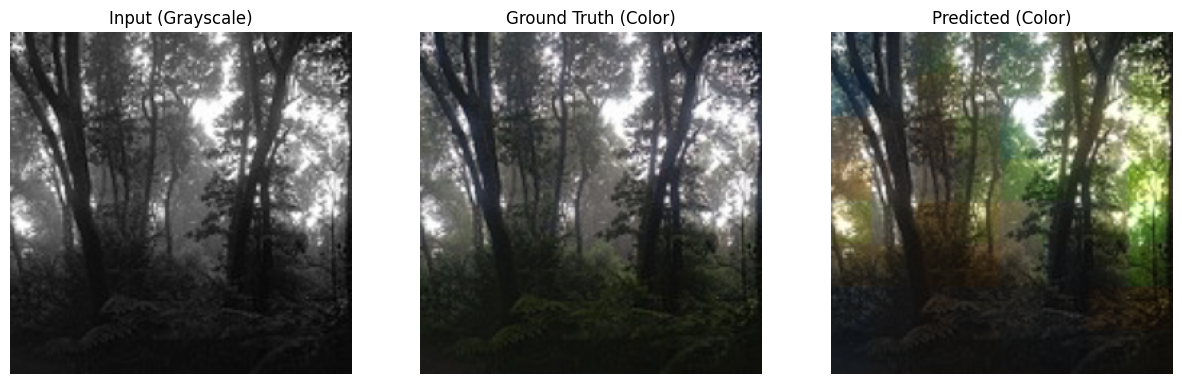

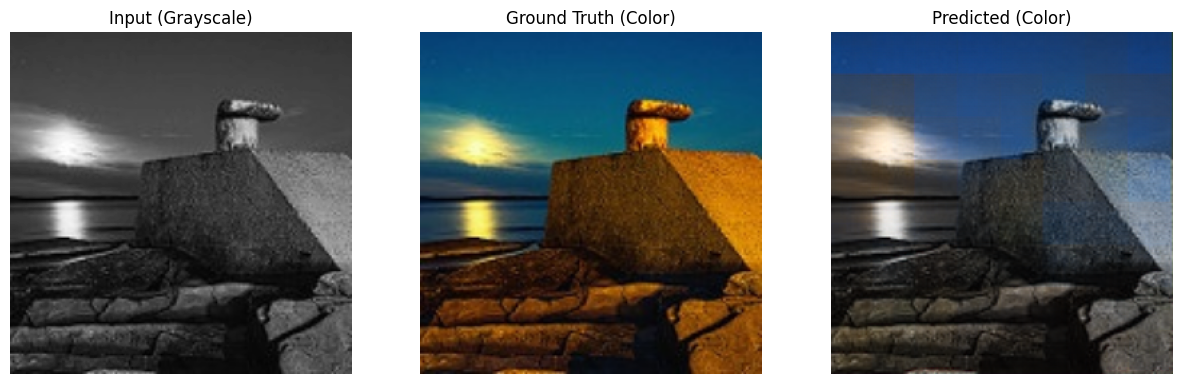

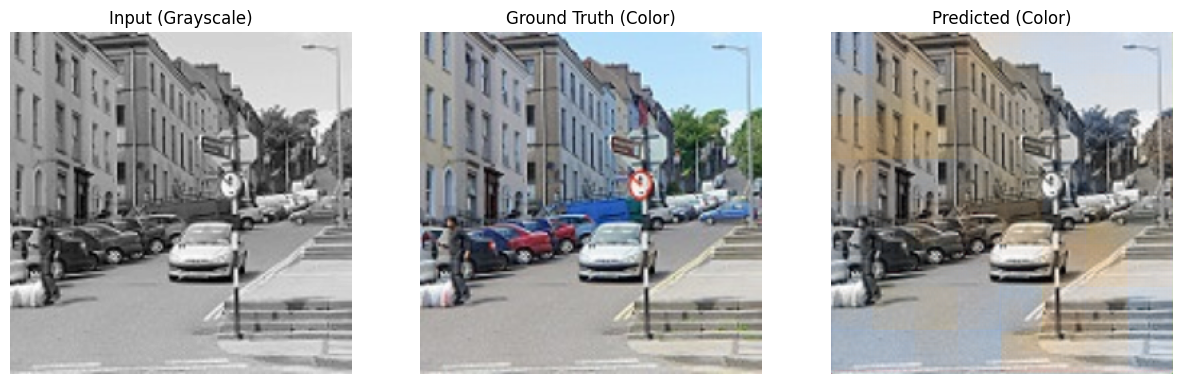

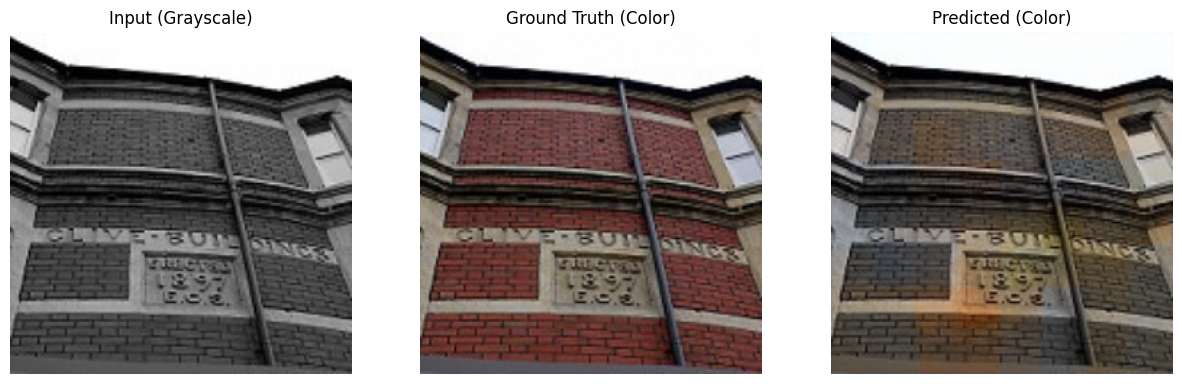

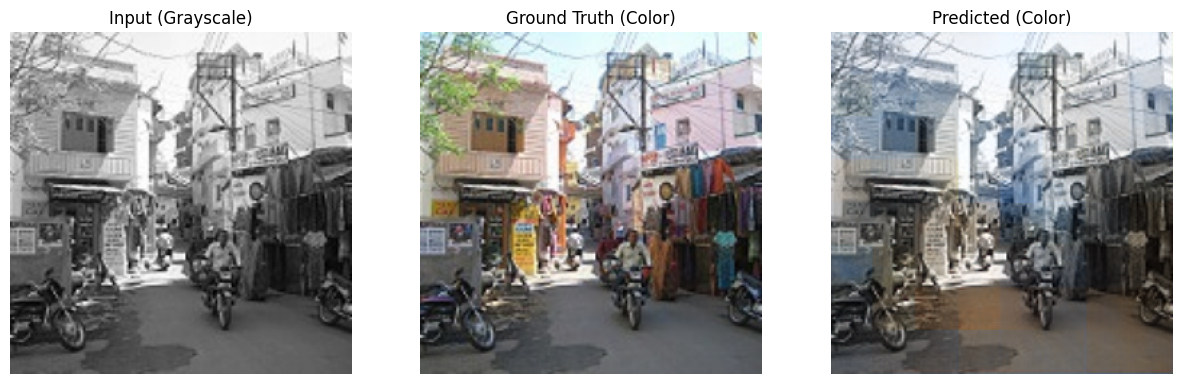

In [16]:
# Prikaz rezultata.
generate_examples(autoencoder, test_generator, num_examples=5)